# Anomaly detection - the data
## Load settings and functions

In [1]:
%run tools.py

## Create dataset

In [2]:
dataset = create_dataset()

Number of training samples to be used:
Please choose a number between 100 and 80819


  10000



Portion of training samples to be attacks:
Please choose a number between 0 and 0.5 .


  0.1



Your dataset has been created.


<div class="alert alert-info">
<h3>Important</h3>

<p>When training the model we will only pass it the features of the samples. The model will never see the class labels, and hence can not gain any feedback from comparing them against its own 'decisions'.<br>
Thus anomaly detection is an <b>unsupervised</b> machine learning approach.</p>
    
<p>However, here we will use the class labels to gain further insight by analysing and visualising the data and later for evaluating our model in some more detail.</p>
</div>

## Explore the training data and visualise 1000 samples

1) We look at the distribution of different attack types in our training data.

2) We use a TSNE-plot to explore part of our training data.  
The TSNE-plot reduces our 51 features to 2 dimensions by trying to represent local structures faithfully.

Your training set has the following composition:


,frequency
class,
normal,9000
neptune,246
ipsweep,169
satan,165
smurf,118
portsweep,114
nmap,59
warezclient,54
back,36


Plotting 1000 samples of the training data


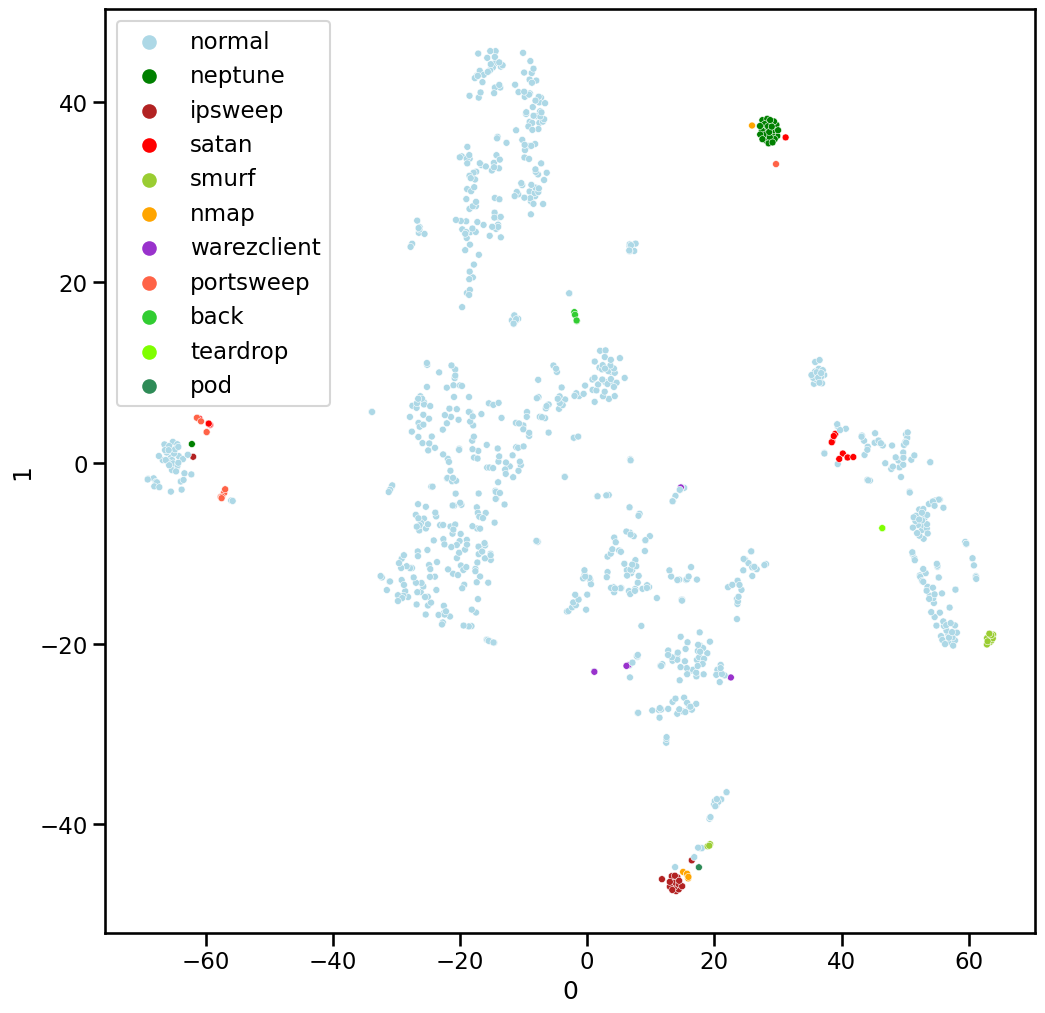

In [3]:
explore_and_visualise_training_data(dataset)

<div class="alert alert-success">
<h2>Let's take a closer look</h2>
    
The following questions are designed to discuss some expectations of the performance of our model and the problems it might encounter.

Note: <i>These questions only make sense for training data that has been contaminated</i>.
    
What do we observe about <br>
<ol>
<li> the <b>frequency of the different malware types</b> in our data set? </li>
<li> the <b>distribution of the different malware types</b> in the TSNE plot? </li>
<li> the <b>distribution of the normal samples</b> in the TSNE plot? </li>
<li><b>Which types of malware</b> do you expect to be <b>easy to find</b>, and which ones would be <b>harder to detect</b>? </li>
</ol>
</div>

Observations for the demo case of 10000 samples with 10% malware:

<ol>
<li> The different malware classes are not evenly distributed. Pod and guess_psswrd are very rare while neptune, ipsweep and satan are fairly common.</li>
<li> Some malware types are forming their own disjoint clusters (here neptune, smurf and ipsweep) <br>
    Some samples are very close to normal samples (here satan, warezclient).</li>
<li> The normal samples form multiple clusters, but there also several that are quite isolated in this plot. These could lead to false alarms. </li>
<li> Malware that is close to many normal samples will be harder to find. Common malware forming clusters might be misinterpreted as sufficiently common and thus as normal.</li>
</ol>

# Anomaly detection - the model
## Training our model

The **expected_contamination** is the portion of anomalies (attacks) that we expect in the real-life test set. This value is independent of the *portion of attacks* we chose to place in the training data.

**PCA (Principal Component Analysis)** transforms our data by trying to identify the directions (= combinations of features) in the data in which the data varies most. This might help the Isolation Forest algorithm to isolate anomalies faster, or it might not. 

In [4]:
model, dataset = build_anomaly_detector(
    dataset,
    expected_contamination=0.1,      # value between 0 and 0.5
    with_PCA = False)                # True / False

## Evaluating the performance

In fo on the plots below:

**Histogram**
* The x-axis gives the scores assigned by the **decision function** to our different samples.  
If it is negative (left side) the sample is considered an anomaly and we interpret this case as a **predicted attack** 
* The color tells us the true class.

**Confusion matrix**: 
* This plot summarizes the histogram according to the true and predicted labels
* The rows correspond to the true classes.
* The columns correspond to the predicted classes. Note that here predicted attacks are on the right side.

1)  Samples with negative scores are marked as anomalies.

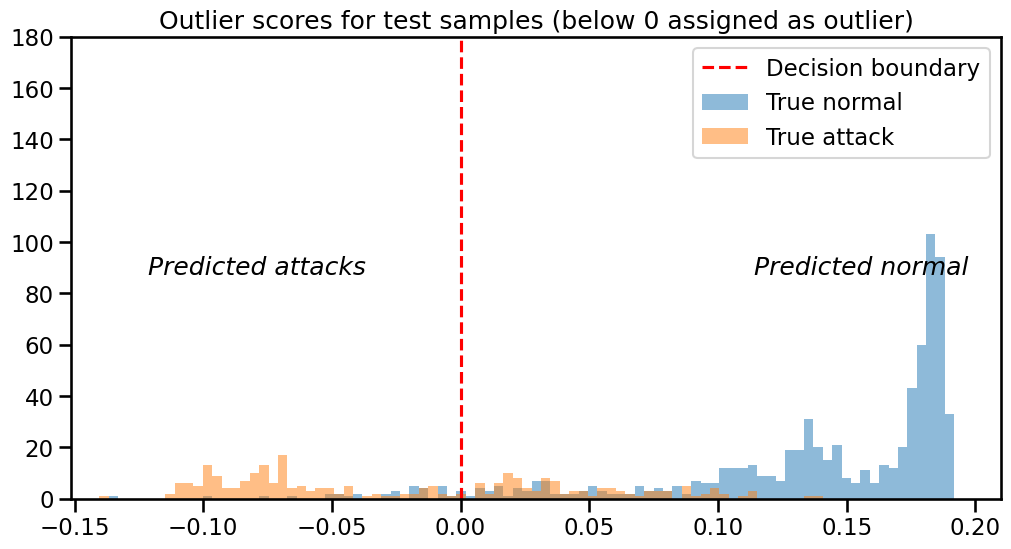

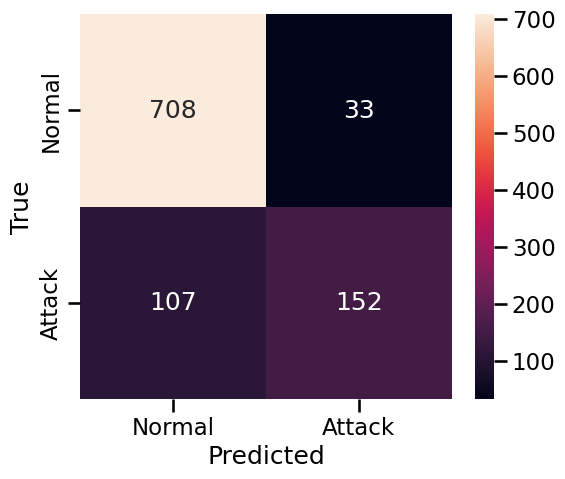

Summary report:
Attacks identified correctly (true positive): 152  of  259 ( 58.7 %)
Attacks missed (false negative): 107  of  259 ( 41.3 %)
False alarms (false positive): 33  of 741 ( 4.5 %)
Total number of misclassified samples: 140


In [5]:
evaluate_model(dataset, model)

<div class="alert alert-success">
<h2>Let's interpret these two plots and their realtionship</h2>

<ol>
<li>  The blue samples on the left side of the histogram correspond to the normal samples labelled as malware, i.e. they are <b>false warnings</b> This corresponds to the top right square of the confusion matrix. In this demo example there are 33 false warnings.</li>
<li>  The orange samples on the right hand side of the histogram correspond malware labelled as normal samples, i.e. they are <b>missed attacks</b> This corresponds to the bottom left square. In this demo example there are 107 missed attacks.</li>
<li>  Which one of these two mispredictions is worse for us? The more costly mispredictions are the missed attacks (irrespective of their precise numbers). Hence we prefer to find a setting where we get fewer missed attacks, while accepting more false alarms.</li>
</ol>

</div>

## Taking a more detailed look at our performance

1) We look at the performance of our predictions at the level of individual attack types.

2) We locate the misclassified samples (triangles, colour gives true label) inside our test set.

Detailed report:


,present,missed,pct_missed
attack_detail,,,
normal,741,33,4.5
neptune,68,0,0.0
satan,40,17,42.5
ipsweep,40,33,82.5
portsweep,32,1,3.1
smurf,29,13,44.8
nmap,16,12,75.0
back,11,10,90.9
warezclient,10,10,100.0


Plotting 1000 samples of the test data




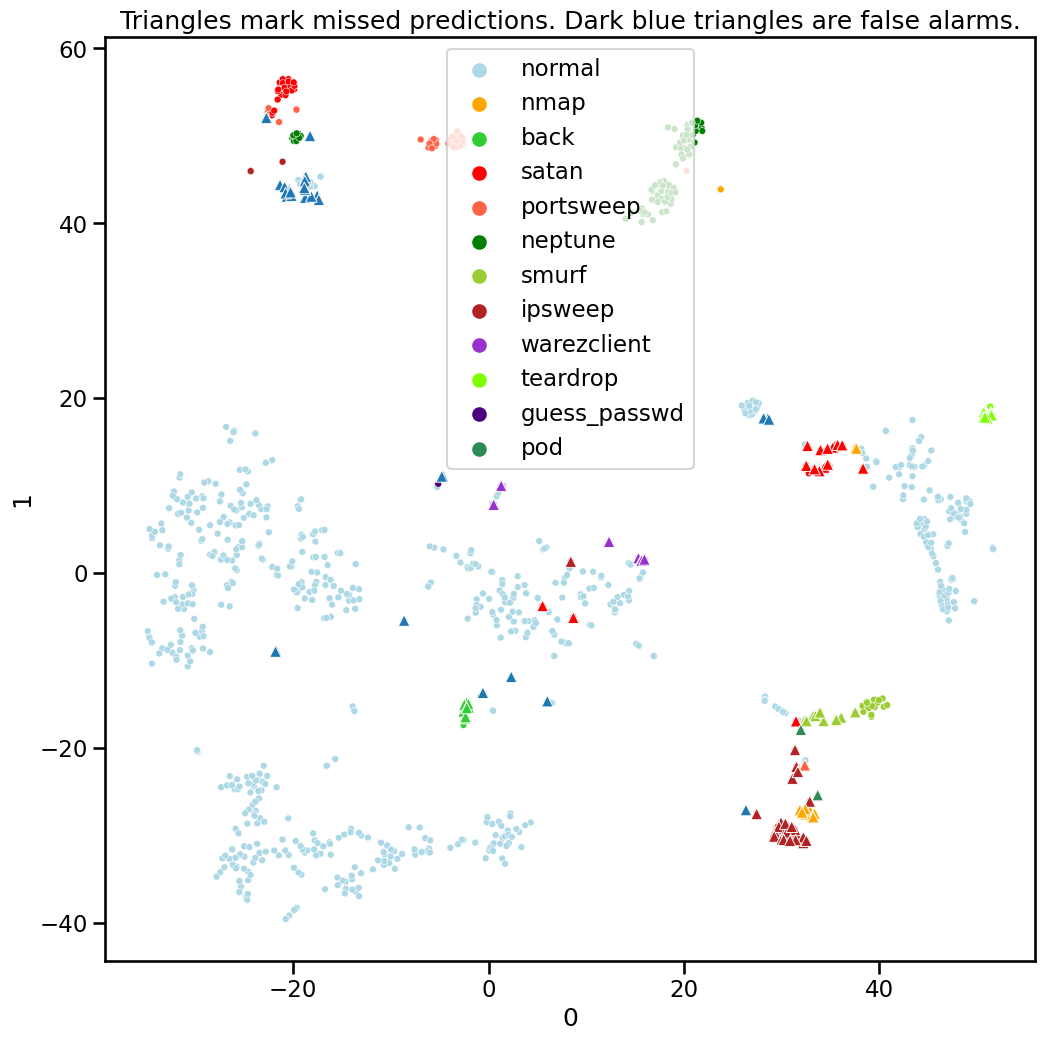

In [6]:
detailed_evaluation(dataset, model)

<div class="alert alert-success">
<h2>Post modelling analysis</h2>

<p>Dark blue triangles indicate <b>false alarms</b>, i.e. normal behaviour that was predicted as malware. <br>
The other triangles indicate malware that was not detected, i.e. <b>missed attacks</b>.</p>

    
Let's compare our earlier expectations with the actual performance. We might ask the following questions

<ol>
<li>  For which types of malware did our model perform well, and for which did it do poorly?</li>
<li>  What do you observe about the location of the false alarms?</li>
<li>  What do you observe about the location of undetected malware?</li>
<li>  Does this match the observations and expectations we made in Part 1?</li>
</ol>

</div>

Observations for the demo case:

<ol>
<li>  Our model perform very well on neptune and portsweep, as expected it struggled with rarer class. Surprisingly it also struggled a lot with ipsweep.</li>
<li>  Some of the false alarms are quite isolated, which might have raised the flag. Others are close to other malware.</li>
<li>  Some missed warezclient and satan samples are hiding amongst the normal samples. But other missed attacks are forming big groups.</li>
<li>  For this demo case this matches our expectations only in parts. It appears that some denser groups in the training data were considered as normal by the model.</li>
</ol> 

# Additional tasks

Unless specified all observations below are based on 10000 samples and 10% malwaree in the training data.

<div class="alert alert-success">
<h2>Task 1</h2>

Let's vary the `expected_contamination` parameter which is used by the model to make decisions. <br>     You only need to run cells in section 2 "Anomaly detection - the model" <br>    
What do you observe about distribution of the outlier scores and the position of the decision boundary?<br>
</div>

Setting `expected_contamination` to 0.2 shifts the decision further to the right, thus resulting in more false alarms but far fewer missed attacks. In particular, nmap, smurf and ipsweep faired better.

<div class="alert alert-success">
<h2>Task 2</h2>

You need to rerun the entire notebook here. <br>
1. Vary the size of your training data.<br> 
2. Vary the portion of attacks in your training data.<br>
3. In particular let's see how the model performs when we only use totally clean training data without any anomalies.<br>
</div>

Training on 10000 but with 0% malware gives better results (43 missed attacks). Neptune, ipsweep and portsweep were detected perfectly. Smurf and nmap were quite good to.

<div class="alert alert-success">
<h2>Task 3</h2>
    
Let's see whether using PCA before training our model helps. <br> 
You only need to run cells in  section 2 "Anomaly detection - the model"<br>
    
Set `with_PCA = True` inside the `build_anomaly_detector`. <br>
</div>

In this particular case it made things even worse (150 missed attacks). In particular neptune failed.

On 10000 clean samples it made an improvement (31 missed attacks)